# Breast Cancer Prediction Using Support Vector Machine (SVM) Binary Classifcation
## By: Jeremy Rico
## Timestamp: 23 Jul, 2020 11:13

## Background Information

Introduction:

Breast cancer is the most common type of cancer in women worldwide. With massive amounts of research being done in this area, it is well knows that early detection is one of the most important factors when it comes to saving the life of the patient. Modern Machine Learning techniques can play a large role in identifying whether a tumor is malignant (cancerous) or benign (not cancerous). This projects aims to identify a tumor as malignant or benign based on its physical charactieristics. By recognizing the danger of the tumor early, the patient has a much greater chance of surviving.

Desctiption:

The code works by using a Support Vector Machine (SVM) to classify the input as either one of two options (0 or 1, hence the binary classification). By feeding the network multiple samples of tumors which have already been classified has malignant or benign, it will be able to identify new cases with a high accuracy. 

Attribute information:

The network will be fed digitized images of a fine needle aspirate (FNA) of breast mass. Each image will be labeled with an ID number and an M (malignant) or a B (benign). Then, we will calculate 10 features of the cells in the images as seen below.

Attributes: 

1. ID Number
2. Diagnosis (M = malgnant, B = benign)

Features to be computed for each cell nucleus:

1. Radius (mean of distance from center to points on the perimeter)
2. Texture (std deviation of gray scale values)
3. Perimeter
4. Area
5. Smoothness (local variation in radius lengths)
6. Compactness (perimeter^2 / area - 1.0)
7. Concavity (severity of concave portions of the contour)
8. Concave points (number of concave portions of the contour)
9. Symmetry
10. Fractal dimension ("coastline approximation" - 1)


## Data

Cancer data will be imported from Sklearn library, but it can also be found here for download:

http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29

The data was obtained from cancer research performed at the University of Wisoncsin. 

## Begin Code

Import python libraries and download dataset

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

# Import dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

The data is now downloaded and saved in the "data" variable, however, it is difficult to read in its current format. Next we will be performating some visulatiztion techiniques to get a better grasp on what the dataset can tell us.

### View in a Dataframe

In [84]:
df = pd.DataFrame(np.c_[data['data'], data['target']], columns = np.append(data['feature_names'], ['target']))

df.head() # pd.head() defaults to showing the first 5 instances of the data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


In [85]:
# Print Data Shape
print("Data Shape:", df.shape[0], "instances,", df.shape[1], "attributes ")

# df.columns # uncomment left to see list of all 31 attribute names

# Print number of instances of each target value
targ_count = df['target'].value_counts()
print("Malignant:", targ_count[0],"\nBenign:", targ_count[1])

Data Shape: 569 instances, 31 attributes 
Malignant: 212 
Benign: 357


### Data Visualization

Firstly, lets plot out just the first five attributes (for all 569 instances) and label each data point according to its target value

1.0 (Orange) = Benign

0.0 (Blue) = Malignant

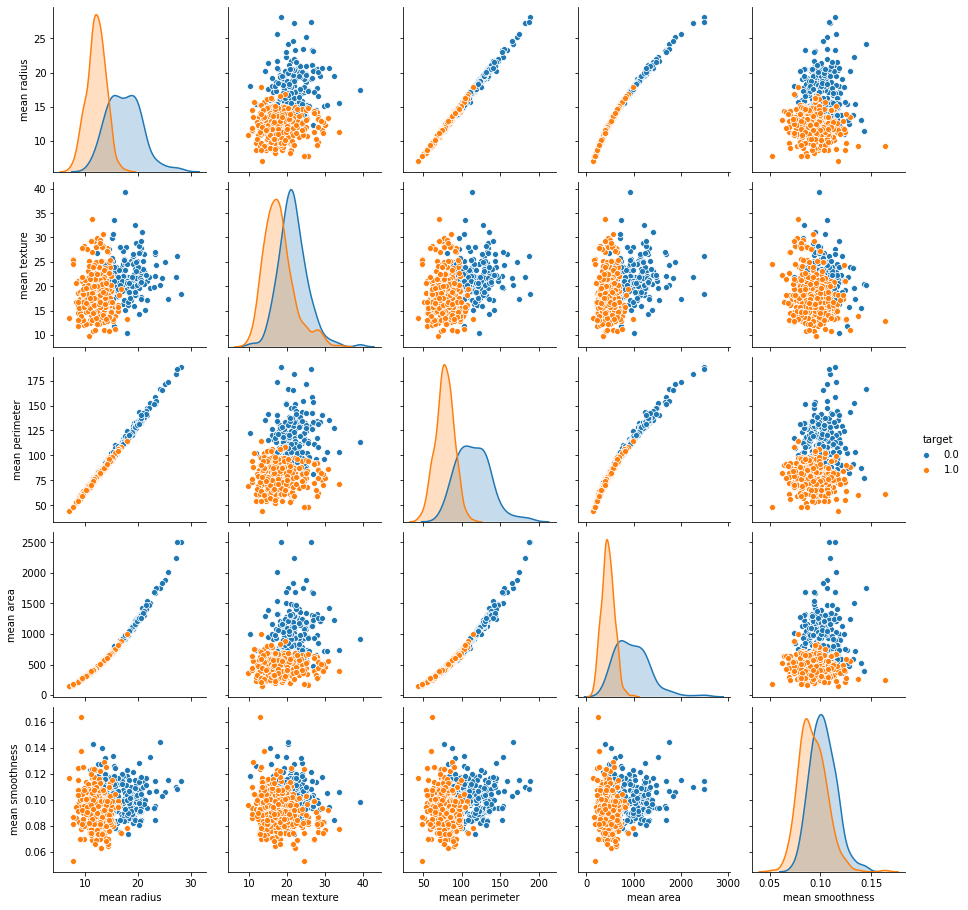

In [86]:
sns.pairplot(df, hue = 'target', vars = ['mean radius', 'mean texture', 'mean perimeter','mean area','mean smoothness'] )

It looks like there is a pattern emerging from some of these plots. However, it doesn't look like any are clearly linearly seperable. Therefore, we will need to adjust our SVM kernal to one that can addapt the this data, but we'll get to that later.

Next, let's use a heatmap to observe the correlation between features:

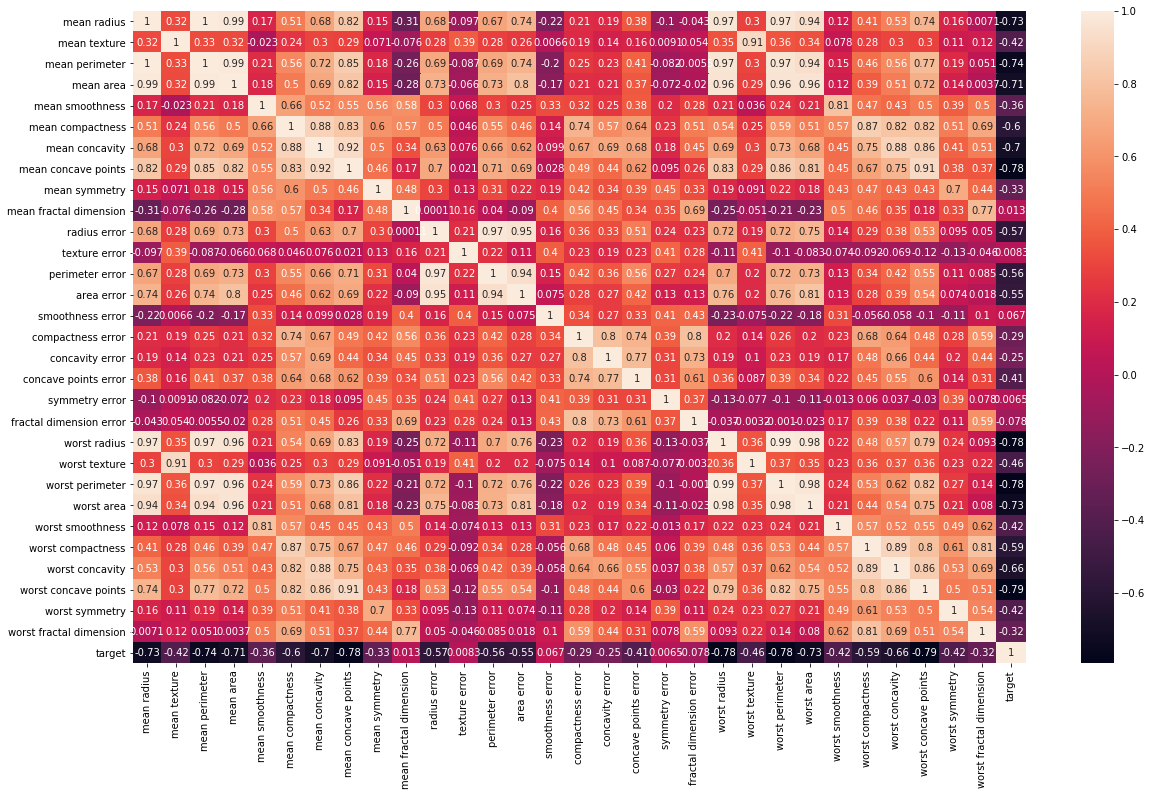

In [87]:
plt.figure(figsize=(20,12)) 
sns.heatmap(df.corr(), annot=True)

The closer the number is to +1.0, the stronger the correlation between the two overlapping features. Therefore, we can observe that there is a strong correlation between mean radius and mean perimeter as well as mean area and mean perimeter.

### Data Manipulation

In order to get the data in a suitable format to feed into a SVM we must do some basic data manipulation.

First, we have to divide the feature values from the target values. These will be saved as X and y, respectivley.

In [88]:
X = df.drop(['target'], axis = 1) # X is now a feature vector with the target value "dropped"

y = df['target'] # y is the target vector consisting of only the target values for each instance

In order to train an SVM (and most other ML/ANN networks) we must divide the data into a training set and a test set. The training set will be what the network will use to learn and make new predictions. The test set will be used to calculate the accuracy of the model's predictions.

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20) # Use skLearn's built in train test split function

print(X_train.shape[0], "training samples,", X_test.shape[0], "test samples")

455 training samples, 114 test samples


### SVM Implementation

In [90]:
# create new instance of an SVM
svc_model = SVC()

# fit the model using the training data
svc_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Now we can use our trained model to make some predictions on the testing data.

Quickly, we can get the accuracy of our model compared to the test set. 

In [91]:
print("Accuracy:", svc_model.score(X_test, y_test))

Accuracy: 0.9298245614035088


This is a fairly high accuracy, but it doesn't tell us enough information about how our model is predicting. For a more detailed description, we can create a confustion matrix.

A confusion matrix will give us a count of four different types of predictions:

    True Positive: A positive class observation (1) is correctly classified as positive by the model.

    False Positive: A negative class observation (0) is incorrectly classified as positive.

    True Negative: A negative class observation is correctly classified as negative.

    False Negative: A positive class observation is incorrectly classified as negative.



In [92]:
y_predict = svc_model.predict(X_test)

# initiate confusion matrix as np array
cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
# rows are labeled values, columns are predicted values. Values along the main diagnol are "correct" predictions.
conf_mat = pd.DataFrame(cm, index=['is_M', 'is_B'],
                         columns=['pred_M','pred_B'])
conf_mat

,pred_M,pred_B
is_M,66,0
is_B,8,40


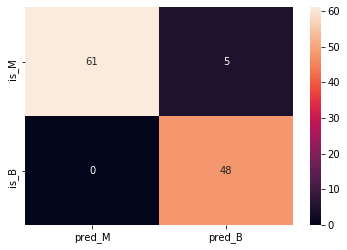

In [93]:
sns.heatmap(confusion, annot=True)

In [94]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       1.00      0.83      0.91        48
         1.0       0.89      1.00      0.94        66

    accuracy                           0.93       114
   macro avg       0.95      0.92      0.93       114
weighted avg       0.94      0.93      0.93       114



As we can see, the model made 106 correct predictions on the test set. All 66 of the malignant tumors, and 40 of the 48 benign tumors, were identified correctly. The report above breaks down some of the more specific capabilities of the network. It reached a 100% accuracy on the malignant tumors and 89% on the benign tumors. This is fairly high accracy, however, perhaps we can do even better by normalizing the data.

### Data Normalization

By normalizing the data, we will being all feature values within a specified range. In this case (and in most ML cases) we will use the range [0, 1]

We will use the following normalization equation for the every element in X:

$$X' = (X-X_{min}) / (X_{max} - X_{min})$$

In [95]:
X_train_scaled = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_train_scaled.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
412,0.114345,0.391003,0.110290,0.053150,0.293907,0.126219,0.087512,0.025487,0.108081,0.401860,...,0.072394,0.418354,0.080681,0.028460,0.247177,0.156601,0.149201,0.088110,0.192682,0.242818
461,0.967343,0.549827,0.988943,1.000000,0.605735,0.550334,0.851687,0.839463,0.505556,0.145814,...,1.000000,0.509582,1.000000,1.000000,0.426137,0.386442,0.545767,0.902062,0.255643,0.126131
532,0.317052,0.205882,0.303849,0.183245,0.435973,0.163088,0.041050,0.093439,0.288384,0.269535,...,0.281750,0.208097,0.254943,0.144564,0.364723,0.125263,0.096326,0.299107,0.294844,0.149416
495,0.373373,0.340138,0.361620,0.227953,0.469643,0.196522,0.159888,0.246074,0.215657,0.174884,...,0.287442,0.431579,0.266398,0.147070,0.333025,0.108188,0.135783,0.349485,0.191019,0.071822
13,0.419755,0.469550,0.414000,0.271135,0.340828,0.247899,0.232849,0.266600,0.397475,0.079535,...,0.316969,0.409447,0.306738,0.169903,0.276894,0.160191,0.185463,0.384536,0.295557,0.051358


As we can see, all attribute values now lay between the range of 0 and 1. Lets apply this tactic to the test set and then try re taining our syste

In [96]:
X_test_scaled = (X_test - X_test.min()) / (X_test.max() - X_test.min())

### SVM with normalized data

In [97]:
svc_model = SVC()
svc_model.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [98]:
y_predict = svc_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_predict)

cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_M', 'is_B'],
                         columns=['pred_M','pred_B'])
confusion

,pred_M,pred_B
is_M,61,5
is_B,0,48


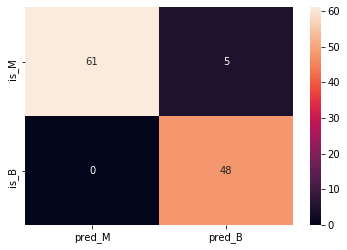

In [99]:
sns.heatmap(confusion,annot=True,fmt="d")

In [100]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95        48
         1.0       1.00      0.92      0.96        66

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



### Experimenting with different kernel types

Now that we have the data normalized, we can experiement with using different types of kernels for our SVM. This will change the method in which the SVM makes a barrier between the two different types of data.

The SCV implementation defaultes to using the Radial Basis Funtion or RBF kernel, but there are a few different types we can try in the scikit-learn library.

In [101]:
#linear
svc_linear = SVC(kernel='linear')
svc_linear.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [102]:
#polynomial
svc_poly = SVC(kernel='poly')
svc_poly.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [103]:
#sigmoid
svc_sig = SVC(kernel='sigmoid')
svc_sig.fit(X_train_scaled, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [104]:
print("Linear Kernel Accuracy:", svc_linear.score(X_test_scaled, y_test))
print("Polynomial Kernel Accuracy:", svc_poly.score(X_test_scaled, y_test))
print("Sigmoid Kernel Accuracy:", svc_sig.score(X_test_scaled, y_test))

Linear Kernel Accuracy: 0.9912280701754386
Polynomial Kernel Accuracy: 0.8596491228070176
Sigmoid Kernel Accuracy: 0.35964912280701755


Surprisingly, the linear kernel (which simply draws a straight line to draw a classification boundary) achieves the highest accuracy. So lets see more specifically how it performed. 

In [105]:
y_predict = svc_linear.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_predict)

cm = np.array(confusion_matrix(y_test, y_predict, labels=[1,0]))
confusion = pd.DataFrame(cm, index=['is_M', 'is_B'],
                         columns=['pred_M','pred_B'])
confusion

,pred_M,pred_B
is_M,65,1
is_B,0,48


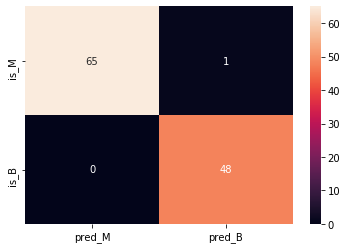

In [106]:
sns.heatmap(confusion,annot=True,fmt="d")

In [107]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        48
         1.0       1.00      0.98      0.99        66

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



Only one wrong prediction. Not bad! This is the highest accuracy we have achieved so far.

### Further Improvement

This model could be improved more by performing a grid search for the most efficienct hyperparameters. SciKit-learn includes a functionality that will create a grid based on the model and define the best hyperparameters for the system. These parameters can then be plugged in when intitializing the model. This method proves highly effective at reaching high accuracy.

It could also be improved by increasing the amount of training samples since the dataset we used was relativley small for a machine learning project.

### Sources

1. https://github.com/nalamidi/Breast-Cancer-Classification-with-Support-Vector-Machine/blob/master/Breast%20Cancer%20Classification.ipynb

2. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

3. http://scikit-learn.org/stable/modules/svm.html

4. https://seaborn.pydata.org/generated/seaborn.heatmap.html

5. http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29